In [1]:
%reload_ext rich

# Basic Imports
import torch
import pytorch_lightning as pl
import numpy as np
from matplotlib import pyplot as plt

import vector
import tree
from rich import progress

2024-07-20 18:21:48.477908: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-20 18:21:48.686374: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from spanet import Options ,JetReconstructionModel
from helper import *

In [3]:
USE_GPU = False

# Load Options
Deep Learning typically has many hyper-parameters that define the structure of the neural network or the training dynamics. Here we load a set of parameters for our network. These values were determined through a tuning procedure we do not cover here. Most libraries define a good set of starting parameters, which typically only need a few changes for specific problems. We highlight a couple of important hyper-parameters.

- **Hidden Dimensionality** The size of the internal representation of events stored in the neural network.
- **Layer Count** The number of various hidden layers in the network. Used to balance the power of the network with over-fitting potential.
- **Learning Rate** The coefficient controlling the size of gradient updates during training.

In [4]:
options = Options.load("options.json")
options.display()

                                                   Configuration                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Parameter                          ┃ Value                                                                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ assignment_loss_scale              │ 1.0                                                                        │
│ balance_classifications            │ 0                                                                          │
│ balance_jets                       │ 0                                                                          │
│ balance_losses                     │ 1                                                                          │
│ balance_particles                  │ 0                                                                          │
│ batch_size                         │ 512                                                                        │
│ classification_loss_scale          │ 0.0                                                                        │
│ combinatorial_scale                │ 0.0                                                                        │
│ combine_pair_loss                  │ min                                                                        │
│ dataset_limit                      │ 1.0                                                                        │
│ dataset_randomization              │ 0                                                                          │
│ detection_loss_scale               │ 1.0                                                                        │
│ dropout                            │ 0.2                                                                        │
│ epochs                             │ 500                                                                        │
│ event_info_file                    │ semi_leptonic_ttbar.yaml                                                   │
│ focal_gamma                        │ 1.0                                                                        │
│ gradient_clip                      │ 0.0                                                                        │
│ hidden_dim                         │ 128                                                                        │
│ initial_embedding_dim              │ 16                                                                         │
│ initial_embedding_skip_connections │ 1                                                                          │
│ kl_loss_scale                      │ 0.0                                                                        │
│ l2_penalty                         │ 0.0002                                                                     │
│ learning_rate                      │ 0.0015                                                                     │
│ learning_rate_cycles               │ 1                                                                          │
│ learning_rate_warmup_epochs        │ 1.0                                                                        │
│ limit_to_num_jets                  │ 0                                                                          │
│ linear_activation                  │ gelu                                                                       │
│ linear_block_type                  │ GRU                                                                        │
│ linear_prelu_activation            │ 1                                                                          │
│ mask_sequence_vectors              │ 1                                                                          │
│ masking                            │ Filling          

# Create Network and Load Data

We begin by loading the data and constructing the neural network. We use a SPANet code for this, but in general, machine learning involves.

1. Loading the training and testing data and performing and pre-processing.
2. Loading the mathematical definition of the network.
3. Constructing the initial set of learnable parameters which will define the neural network's outputs.

In [5]:
model = JetReconstructionModel(options)

if USE_GPU:
    model = model.cuda()
    
# Build an optimizer which will keep track of the gradient descent procedure.
(optimizer, ), _ = model.configure_optimizers()

Index Range: 0...2951564
Index Range: 2951565...3106910
Index Range: 0...466458


## Data

### Problem

We will focus on jet-parton assignment in the semi-letponic ttbar channel.

<img src="figures/feynman_diagram.png" width="500">

### Inputs

In supervised deep learning, we have a set of inputs (which we call sources) and output targets.

One of the advantages of deep learning models is the ability to handle multiple types of inputs. Here we have two types of inputs:
- **Momenta** A *variable length* collection 4-momentum vectors for our jets and leptons in each event.
- **MET** The missing energy attributed to the neutrino.

In [6]:
momenta = model.training_dataset.sources["Momenta"]
met = model.training_dataset.sources["Met"]

model.training_dataset.sources

OrderedDict([('Momenta', <spanet.dataset.inputs.SequentialInput.SequentialInput object at 0x7fbdcceb8b50>), ('Met', <spanet.dataset.inputs.GlobalInput.GlobalInput object at 0x7fbdcceb8220>)])

Each input has a set of *features* which are measurements we observe from the data. The momentum vectors contain the kinematics and some particle id tags.

In [7]:
momenta.input_features, met.input_features

(
    (
        FeatureInfo(name='mass', normalize=True, log_scale=True),
        FeatureInfo(name='pt', normalize=True, log_scale=True),
        FeatureInfo(name='eta', normalize=True, log_scale=False),
        FeatureInfo(name='sin_phi', normalize=True, log_scale=False),
        FeatureInfo(name='cos_phi', normalize=True, log_scale=False),
        FeatureInfo(name='qtag', normalize=False, log_scale=False),
        FeatureInfo(name='btag', normalize=False, log_scale=False),
        FeatureInfo(name='etag', normalize=False, log_scale=False),
        FeatureInfo(name='utag', normalize=False, log_scale=False)
    ),
    (
        FeatureInfo(name='met', normalize=True, log_scale=True),
        FeatureInfo(name='sumet', normalize=True, log_scale=True),
        FeatureInfo(name='sin_phi', normalize=True, log_scale=False),
        FeatureInfo(name='cos_phi', normalize=True, log_scale=False)
    )
)

(None, None)

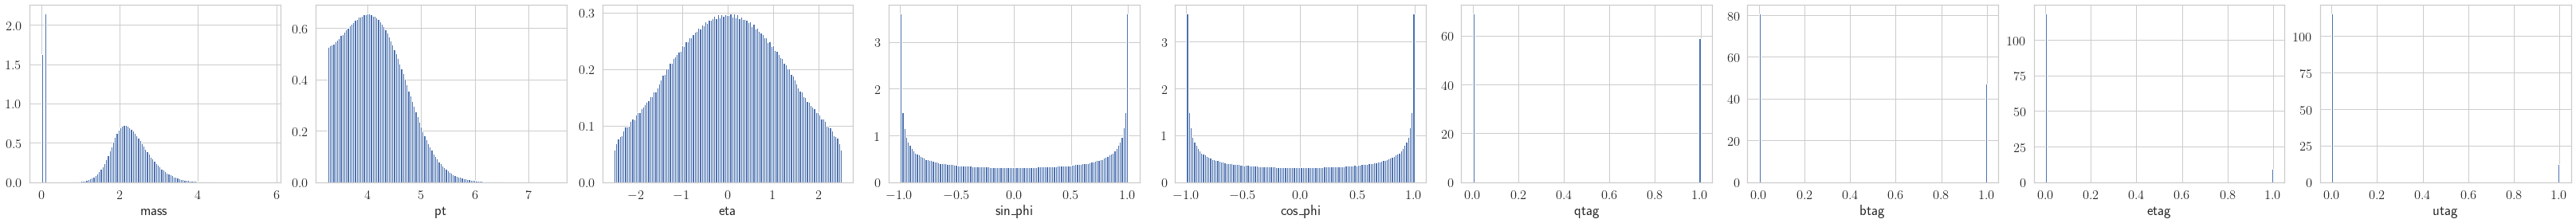

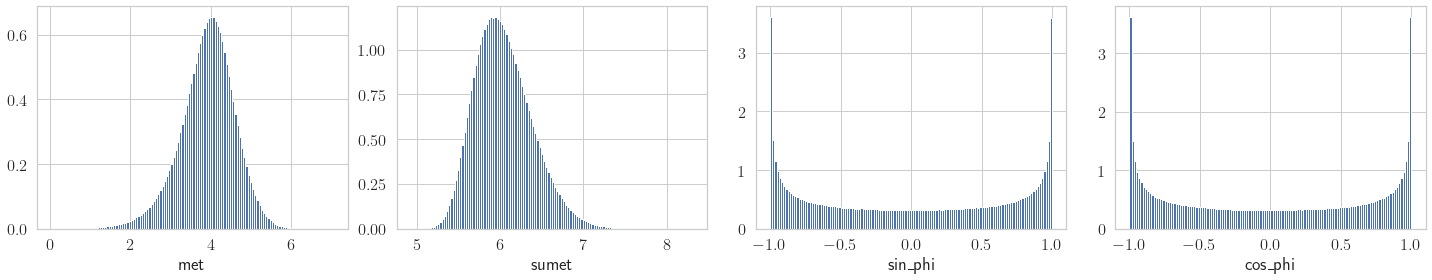

In [8]:
plot_input(momenta), plot_input(met)

Each event contains *up to* 16 momentum vectors, each with the 9 features defined above.  Typically, variable length inputs in machine learning are stored in **padded** form, where we take the longest collection and set all inputs to be the same, longest length. We add padding vectors to the inputs which are shorter and mark these additional vectors as padding with a masking array.

In [9]:
momenta[0].data.shape #momenta[idx], event_idx

torch.Size([16, 9])

In [10]:
momenta[0].mask

tensor([ True,  True,  True,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False])

We can see that most events have between 5 and 7 detector momentum vectors, but we may have up to 16! One of these is guaranteed to be a lepton, and the rest are typically hadronic jets. We include a cut on the simulated data to ensure we only look at events with at least 5 momentum.

In [11]:
momenta.num_vectors().numpy()

array([5, 6, 5, ..., 5, 5, 6])

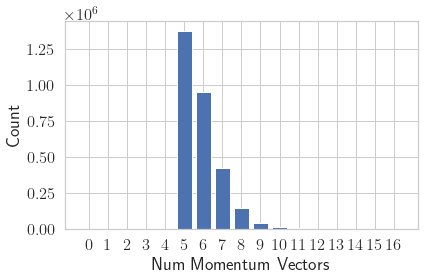

In [12]:
num_vectors = momenta.num_vectors().numpy() #convert tensor array into numpy array, represent the number of jet(vector) in each event
bin_y = np.bincount(num_vectors) #counting the number of event that has jets ranging from 0-16
bin_x = np.arange(bin_y.shape[0]) # .shape[0] gives 17 (bins including 0), then creating  array range from 0-16

plt.bar(bin_x, bin_y)
plt.xticks(bin_x)
plt.xlabel("Num Momentum Vectors")
plt.ylabel("Count")
plt.tight_layout()

Deep learning relies on a large number of examples to statistically extract information about the problem.

In [13]:
print('Number of testing events:', model.testing_dataset.num_events)
print('Number of training events:', model.training_dataset.num_events) #both from trunncated num_events file

Number of testing events: 466459
Number of training events: 2951565


In [11]:
#print("Number of training events:", model.training_dataset.num_events)

Number of training events: 9372132


### Targets

The targets are collections of indices which correspond to originating partons for the jets / leptons. As this data is simulated, we can determine these truth labels from the simulation logs. Note that some decay products are lost at the detector and, as such, some of the events contain missing partons. We indicate these missing partons with a mask. Our event has two groups of assignment partons:

- **leptonic top (lt)** contains a single b quark jet. We do not assign the lepton as this event only contains a single lepton.
- **hadronic top (ht)** contains the b quark jet and two light quark jets.

In [14]:
model.training_dataset.assignments

OrderedDict([('lt', (tensor([[2],
        [4],
        [3],
        ...,
        [2],
        [2],
        [2]]), tensor([True, True, True,  ..., True, True, True]))), ('ht', (tensor([[ 3,  1, -1],
        [ 1,  2, -1],
        [-1,  4, -1],
        ...,
        [ 1,  3,  4],
        [ 1,  3, -1],
        [ 4,  3,  5]]), tensor([False, False, False,  ...,  True, False,  True])))])

In [15]:
lt_indices, lt_mask = model.training_dataset.assignments["lt"]
ht_indices, ht_mask = model.training_dataset.assignments["ht"]

Lets gather all of the true assignments for our dataset. We use a helper function to index the dataset and return (valid) collections of jets for each resonance particle.

In [20]:
lt_momenta = assignment_index(momenta.source_data, lt_indices, lt_mask)
ht_momenta = assignment_index(momenta.source_data, ht_indices, ht_mask)

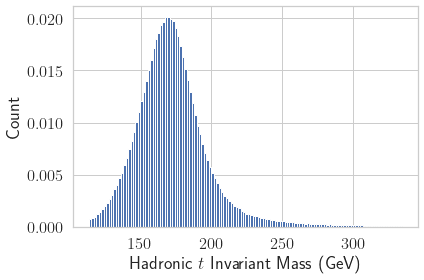

In [21]:
plot_distribution(invariant_mass(ht_momenta))
plt.xlabel("Hadronic $t$ Invariant Mass (GeV)")
plt.ylabel("Count")
plt.tight_layout();

## Network

The SPANet architecture is specialized to produce joint distributions over the input momentum vectors indicating the likelihood that a given assignment is correct. We have many additional outputs available, but we will focus on the assignment and detection probability outputs in this demo. 

The foundational unit of this architecture is the **transformer** - a special type of layer which finds the pairwise similarity between elements in a set and extract information from these similarities and differences. Our architecture follows the structure of the Feynman diagram above. 

The architecture is the primary location we can encode our knowledge of the underlying physics within the neural network. We choose this transformer architecture because it is invariant to the order of the inputs, and it allows us to produce symmetric output distributions. 

The architecture defines a functional approximation of our desired target. This approximation is parameterized by a set of learnable **parameters**, like coefficients in a Taylor expansion. These are the parts of the model which we update during training. During initialization, we set these parameters to random values.

<img src="figures/network_diagram.png" width="500">

In [89]:
# Take the first event as an example to evaluate the network.
example_event = model.training_dataset[:1]

if USE_GPU:
    example_event = batch_to_gpu(example_event)
    
# Calculate the number of true (non-padding) momentum vectors in this event.
num_vectors = example_event.sources[0].mask.sum().item() # .item() to convert tensor to int

In [90]:
# Run the event through the SPANet to extract the predictions.
model.eval()
predictions = model(example_event.sources)

In [95]:
predictions.assignments

[
    tensor([[-1.6105, -1.6093, -1.6086, -1.6089, -1.6099,    -inf,    -inf,    -inf,
            -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf]],
       grad_fn=<ViewBackward0>),
    tensor([[[[   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf, -4.0943,  ...,    -inf,    -inf,    -inf],
          [   -inf, -4.0943,    -inf,  ...,    -inf,    -inf,    -inf],
          ...,
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf]],

         [[   -inf,    -inf, -4.0943,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [-4.0943,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          ...,
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf]],

         [[   -inf, -4.0943,    -inf,  ...,    -inf,    -inf,    -inf],
          [-4.0943,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          ...,
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf]],

         ...,

         [[   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          ...,
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf]],

         [[   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          ...,
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf]],

         [[   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          ...,
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf]]]],
       grad_fn=<ViewBackward0>)
]

### Assignment Outputs
These produce the likelihood that a given collection of jets (and leptons) are assignment to a given resonance particle **given** that all of the resonance particle daughters can be found in the event (the particle is *reconstructable*). Decay products may often be lost due to gaps in the detector or multiple jets combining into one. This problem is especially channels with many final-state particles.

$$ P_{assignment}(j_1, j_2, \dots, j_{k_p} \mid p \text{ reconstructable}). $$

In [96]:
# Network produces log-probabilities for numerical stability.
# 
# Extract the two 1d distributions for the b quarks 
# and the pairwise distribution for the pair of light quarks.
# 
leptonic_b_assignment = torch.exp(predictions.assignments[0]) #torch.exp because predictions are log-probability
hadronic_b_marginal_assignment = torch.exp(predictions.assignments[1]).sum((2, 3))
hadronic_qq_marginal_assignment = torch.exp(predictions.assignments[1]).sum(1)

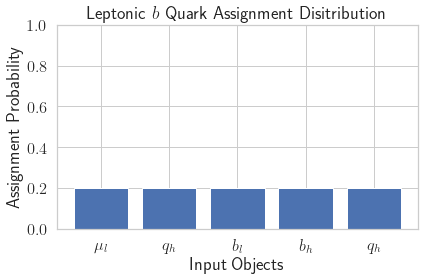

In [97]:
plot_1d_assignment_distribution(torch.exp(predictions.assignments[0]), num_vectors)
plt.xticks(*make_labels(example_event))
plt.ylim(0.0, 1.0)
plt.xlabel("Input Objects")
plt.title("Leptonic $b$ Quark Assignment Disitribution")
plt.tight_layout();

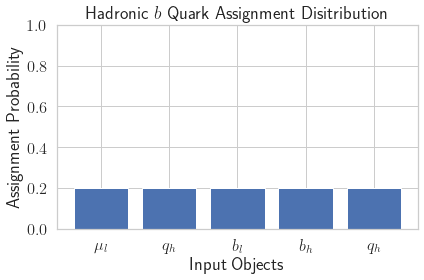

In [98]:
plot_1d_assignment_distribution(hadronic_b_marginal_assignment, num_vectors)
plt.xticks(*make_labels(example_event))
plt.ylim(0.0, 1.0)
plt.xlabel("Input Objects")
plt.title("Hadronic $b$ Quark Assignment Disitribution")
plt.tight_layout();

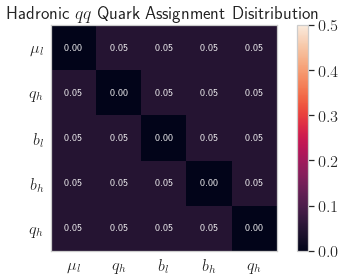

In [99]:
plot_2d_assignment_distribution(hadronic_qq_marginal_assignment, num_vectors)
plt.xticks(*make_labels(example_event), minor=True)
plt.yticks(*make_labels(example_event), minor=True)
plt.title("Hadronic $qq$ Quark Assignment Disitribution")
plt.tight_layout();

## Detection Outputs

To fully characterize the event, we also need to measure the probability that a given particle is even reconstructable in the event. This would be to determine the likelihood of the condition on the assignment distribution, and would give us a way to cut on events we don't think we can reconstruct.

$$ P_{detection}(p \text{ reconstructable}). $$

In [100]:
for x in predictions.detections:
    print(x, x[0])

tensor([-0.2140], grad_fn=<SqueezeBackward1>) tensor(-0.2140, grad_fn=<SelectBackward0>)
tensor([-0.2166], grad_fn=<SqueezeBackward1>) tensor(-0.2166, grad_fn=<SelectBackward0>)


In [101]:
[torch.sigmoid(x[0]).detach().cpu().numpy() for x in predictions.detections] #x[0] for accessing the actual data

[array(0.44669524, dtype=float32), array(0.4460649, dtype=float32)]

# Training

Deep learning models are trained through a process known as batch stochastic gradient descent.

1. Sample a small subset of the dataset to evaluate the network on.
2. Evaluate the network on this batch.
3. Compare to the truth value and produce a numerical measure of the error via a **loss** function.
4. Calculate the gradient this loss function with respect to the network's parameter's.
5. Update the parameters by taking a small step towards the gradient.

In [102]:
model.train()

# 1 Sample subset of the data
# -----------------------------------------------------------------------------
batch = next(iter(model.train_dataloader()))

if USE_GPU:
    batch = batch_to_gpu(batch)

# 2 Evaluate the network
# -----------------------------------------------------------------------------
predictions = model(batch.sources)

# 3 Compute Loss
# -----------------------------------------------------------------------------
symmetric_losses, _ = model.symmetric_losses(
    predictions.assignments,
    predictions.detections,
    batch.assignment_targets
)

display_loss_table(symmetric_losses)
loss = symmetric_losses.mean()

# 4 Compute Gradients
# -----------------------------------------------------------------------------
optimizer.zero_grad()
loss.backward()

# 5 Update Parameters
# -----------------------------------------------------------------------------
optimizer.step()

                      Losses                       
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Particle     ┃ Assignment Loss ┃ Detection Loss ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ Leptonic Top │ 1.3535637       │ 0.7289119      │
│ Hadronic Top │ 2.1542869       │ 0.7395252      │
└──────────────┴─────────────────┴────────────────┘

As we often require large datasets and large models to approximate complex functions, we often train neural networks at large scale, across several GPUs.

In [103]:
# Large neural networks are typically trained on several GPUs in parallel.
trainer = pl.Trainer(
    accelerator="gpu", 
    devices=1, 
    
    # Comment these out to do a full training run.
    max_epochs=1,
    overfit_batches=100
)
trainer.fit(model)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_431/1783486513.py:2 in <module>                                                   │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_431/1783486513.py'                          │
│                                                                                                  │
│ /cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/pyto │
│ rch_lightning/utilities/argparse.py:70 in insert_env_defaults                                    │
│                                                                                                  │
│   67 │   │   kwargs = dict(list(env_variables.items()) + list(kwargs.items()))                   │
│   68 │   │                                                                                       │
│   69 │   │   # all args were already moved to kwargs                                             │
│ ❱ 70 │   │   return fn(self, **kwargs)                                                           │
│   71 │                                                                                           │
│   72 │   return cast(_T, insert_env_defaults)                                                    │
│   73                                                                                             │
│                                                                                                  │
│ /cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/pyto │
│ rch_lightning/trainer/trainer.py:401 in __init__                                                 │
│                                                                                                  │
│    398 │   │   # init connectors                                                                 │
│    399 │   │   self._data_connector = _DataConnector(self)                                       │
│    400 │   │                                                                                     │
│ ❱  401 │   │   self._accelerator_connector = _AcceleratorConnector(                              │
│    402 │   │   │   devices=devices,                                                              │
│    403 │   │   │   accelerator=accelerator,                                                      │
│    404 │   │   │   strategy=strategy,                                                            │
│                                                                                                  │
│ /cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/pyto │
│ rch_lightning/trainer/connectors/accelerator_connector.py:152 in __init__                        │
│                                                                                                  │
│   149 │   │   if self._accelerator_flag == "auto":                                               │
│   150 │   │   │   self._accelerator_flag = self._choose_auto_accelerator()                       │
│   151 │   │   elif self._accelerator_flag == "gpu":                                              │
│ ❱ 152 │   │   │   self._accelerator_flag = self._choose_gpu_accelerator_backend()                │
│   153 │   │                                                                                      │
│   154 │   │   self._check_device_config_and_set_final_flags(devices=devices, num_nodes=num_nod   │
│   155 │   │   self._set_parallel_devices_and_init_accelerator()                                  │
│                                                                                                  │
│ /cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/pyto │
│ rch_lightning/trainer/connectors/accelerator_connector.py:3

# Evaluate
We will load an existing pre-trained network for the rest of this example. This network takes roughly a day to train on a single four-GPU node.

## Single Example Event
Lets return to a single example event to see how our assignment distributions have changed. We notice that the network has successfully learned to match the jet to its associated parton. We can examine the full distributions and use these to extract a confidence in the assignment as well.

In [104]:
model = JetReconstructionModel.load_from_checkpoint(
    "lightning_logs/version_0/checkpoints/last.ckpt",
    map_location="cpu", 
    options=options
)

if USE_GPU:
    model = model.cuda()
    
model = model.eval()
for parameter in model.parameters():
    parameter.requires_grad_(False)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_431/751173494.py:1 in <module>                                                    │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_431/751173494.py'                           │
│                                                                                                  │
│ /cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/pyto │
│ rch_lightning/core/module.py:1552 in load_from_checkpoint                                        │
│                                                                                                  │
│   1549 │   │   │   y_hat = pretrained_model(x)                                                   │
│   1550 │   │                                                                                     │
│   1551 │   │   """                                                                               │
│ ❱ 1552 │   │   loaded = _load_from_checkpoint(                                                   │
│   1553 │   │   │   cls,  # type: ignore[arg-type]                                                │
│   1554 │   │   │   checkpoint_path,                                                              │
│   1555 │   │   │   map_location,                                                                 │
│                                                                                                  │
│ /cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/pyto │
│ rch_lightning/core/saving.py:61 in _load_from_checkpoint                                         │
│                                                                                                  │
│    58 ) -> Union["pl.LightningModule", "pl.LightningDataModule"]:                                │
│    59 │   map_location = map_location or _default_map_location                                   │
│    60 │   with pl_legacy_patch():                                                                │
│ ❱  61 │   │   checkpoint = pl_load(checkpoint_path, map_location=map_location)                   │
│    62 │                                                                                          │
│    63 │   # convert legacy checkpoints to the new format                                         │
│    64 │   checkpoint = _pl_migrate_checkpoint(                                                   │
│                                                                                                  │
│ /cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/ligh │
│ tning_fabric/utilities/cloud_io.py:54 in _load                                                   │
│                                                                                                  │
│    51 │   │   │   map_location=map_location,  # type: ignore[arg-type]                           │
│    52 │   │   )                                                                                  │
│    53 │   fs = get_filesystem(path_or_url)                                                       │
│ ❱  54 │   with fs.open(path_or_url, "rb") as f:                                                  │
│    55 │   │   return torch.load(f, map_location=map_location)  # type: ignore[arg-type]          │
│    56                                                                                            │
│    57                                                                                            │
│                                                                                                  │
│ /cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/fssp │
│ ec/spec.py:1307 in open                                    

In [26]:
model.validation_dataset.limit_dataset_to_full_events()
example_validation_event = model.validation_dataset[1:2]
# example_validation_event = model.validation_dataset[0:1]

if USE_GPU:
    example_validation_event = batch_to_gpu(example_validation_event)
num_vectors = example_validation_event.sources[0].mask.sum().item()

In [27]:
example_validation_event.assignment_targets


(
    AssignmentTargets(indices=tensor([[5]], device='cuda:0'), mask=tensor([True], device='cuda:0')),
    AssignmentTargets(
        indices=tensor([[1, 3, 4]], device='cuda:0'),
        mask=tensor([True], device='cuda:0')
    )
)

In [28]:
predictions = model(example_validation_event.sources)

leptonic_b_assignment = torch.exp(predictions.assignments[0])
hadronic_b_marginal_assignment = torch.exp(predictions.assignments[1]).sum((2, 3))
hadronic_qq_marginal_assignment = torch.exp(predictions.assignments[1]).sum(1)

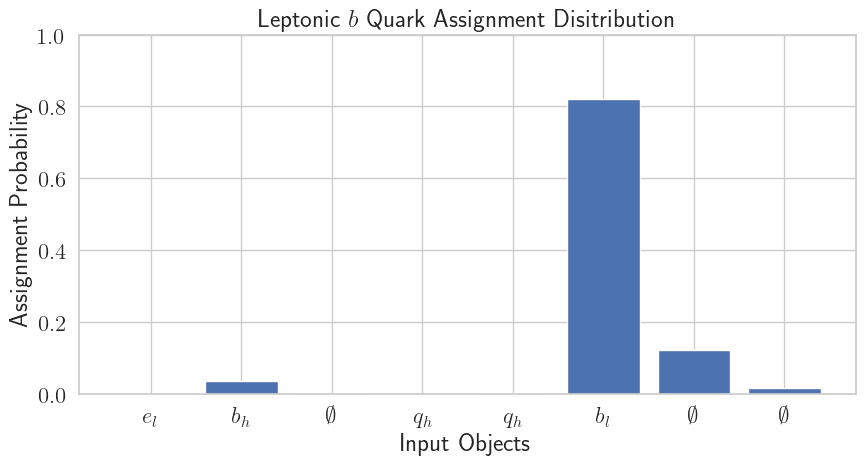

In [29]:
plot_1d_assignment_distribution(torch.exp(predictions.assignments[0]), num_vectors)
plt.xticks(*make_labels(example_validation_event))
plt.ylim(0.0, 1.0)
plt.xlabel("Input Objects")
plt.title("Leptonic $b$ Quark Assignment Disitribution")
plt.tight_layout();

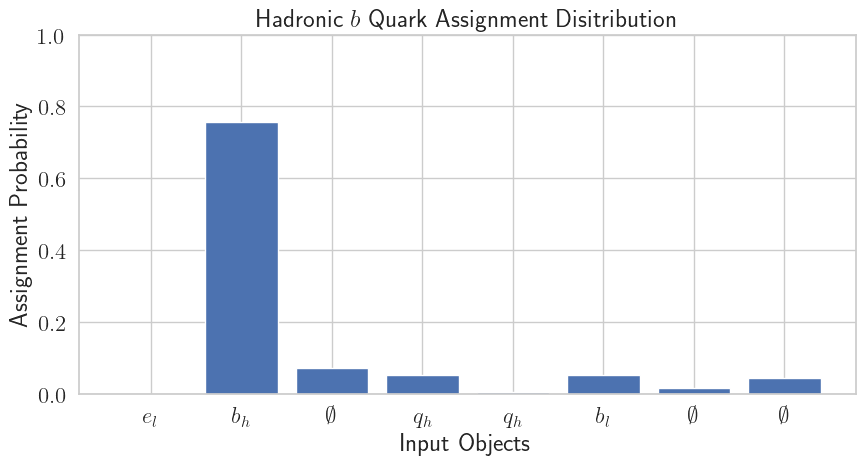

In [30]:
plot_1d_assignment_distribution(hadronic_b_marginal_assignment, num_vectors)
plt.xticks(*make_labels(example_validation_event))
plt.ylim(0.0, 1.0)
plt.xlabel("Input Objects")
plt.title("Hadronic $b$ Quark Assignment Disitribution")
plt.tight_layout();

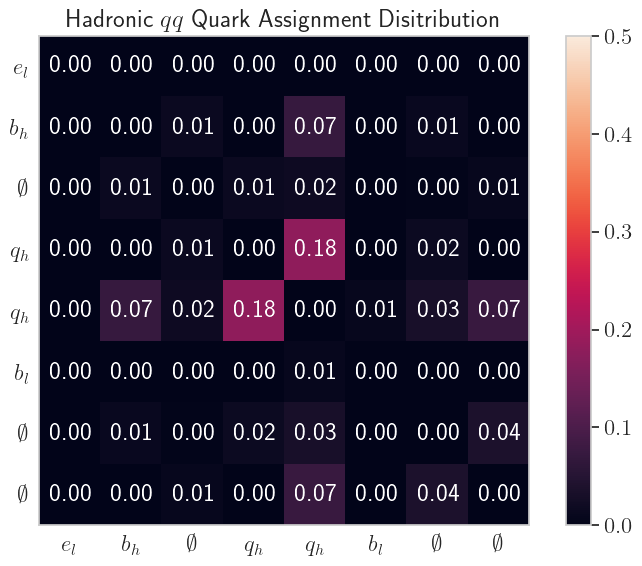

In [31]:
plt.figure(figsize=(8, 6))
plot_2d_assignment_distribution(hadronic_qq_marginal_assignment, num_vectors)
plt.xticks(*make_labels(example_validation_event), minor=True)
plt.yticks(*make_labels(example_validation_event), minor=True)

plt.title("Hadronic $qq$ Quark Assignment Disitribution")
plt.tight_layout();

## Full Testing Dataset Evaluation
Lets now evaluate the entire test dataset and examine how well our model is recovering the assignments.

In [32]:
from spanet.evaluation import evaluate_on_test_dataset
evaluation = evaluate_on_test_dataset(model)

Output()

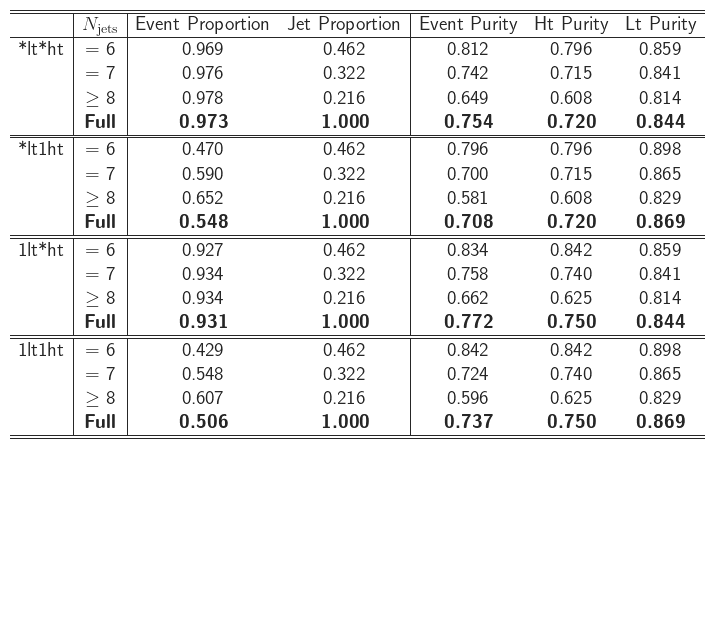

In [33]:
display_results_table(model, evaluation)

## Top Quark Mass Estimate
Now lets find out how well our network is recovering some top kinematics

In [34]:
momenta = model.testing_dataset.sources["Momenta"].source_data
lt_truth, lt_mask = model.testing_dataset.assignments["lt"]
ht_truth, ht_mask = model.testing_dataset.assignments["ht"]

In [35]:
lt_momenta_true = assignment_index(momenta, lt_truth, lt_mask)
lt_momenta_pred = assignment_index(momenta, evaluation.assignments["lt"], lt_mask)
lt_momenta_unmatched = assignment_index(momenta, evaluation.assignments["lt"], ~lt_mask)

ht_momenta_true = assignment_index(momenta, ht_truth, ht_mask)
ht_momenta_pred = assignment_index(momenta, evaluation.assignments["ht"], ht_mask)
ht_momenta_unmatched = assignment_index(momenta, evaluation.assignments["ht"], ~ht_mask)

/Research/Feynman/spanet_demo/demo/helper.py:63: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_8308/4193303837.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


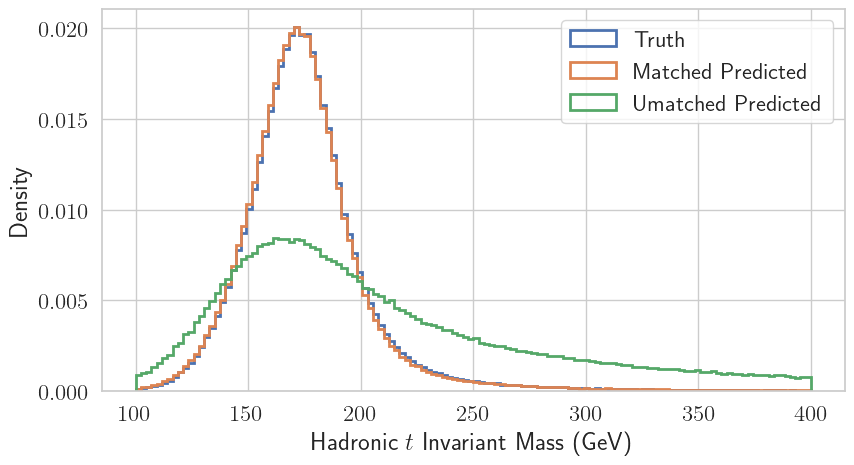

In [36]:
plot_distribution(invariant_mass(ht_momenta_true), line=2, label="Truth", range=(100, 400))
plot_distribution(invariant_mass(ht_momenta_pred), line=2, label="Matched Predicted", range=(100, 400))
plot_distribution(invariant_mass(ht_momenta_unmatched), line=2, label="Umatched Predicted", range=(100, 400))

plt.xlabel("Hadronic $t$ Invariant Mass (GeV)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout();

/tmp/ipykernel_8308/158975327.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


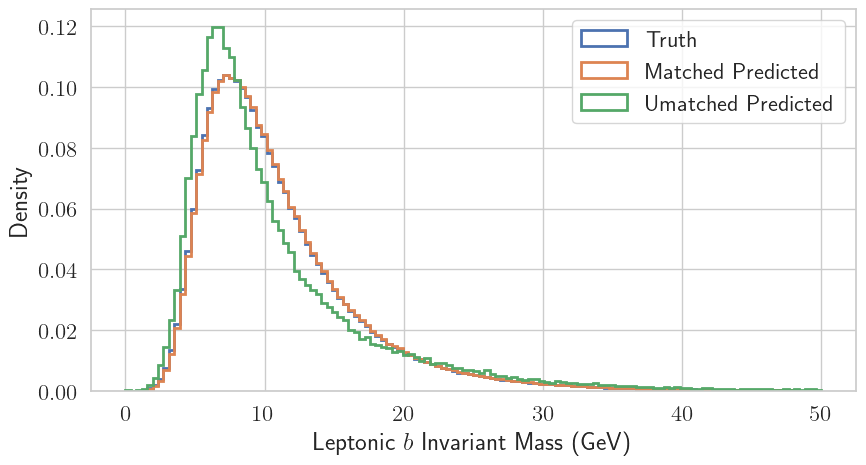

In [37]:
plot_distribution(invariant_mass(lt_momenta_true), line=2, label="Truth", range=(0, 50))
plot_distribution(invariant_mass(lt_momenta_pred), line=2, label="Matched Predicted", range=(0, 50))
plot_distribution(invariant_mass(lt_momenta_unmatched), line=2, label="Umatched Predicted", range=(0, 50))

plt.xlabel("Leptonic $b$ Invariant Mass (GeV)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout();

## Using the detection outputs
Lets looks at our detection probabilites for different kinds of events. We notice the network learned to identify missing jets pretty consistently.

/tmp/ipykernel_8308/973651906.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


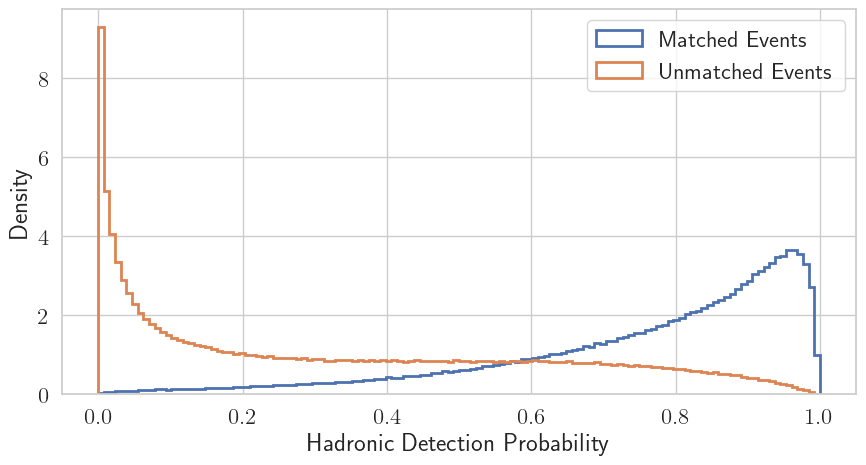

In [38]:
plot_distribution(evaluation.detection_probabilities["ht"][ht_mask], line=2, label="Matched Events", range=(0, 1))
plot_distribution(evaluation.detection_probabilities["ht"][~ht_mask], line=2, label="Unmatched Events", range=(0, 1))
plt.xlabel("Hadronic Detection Probability")
plt.ylabel("Density")
plt.legend()
plt.tight_layout();

The **Receiver Operating Characteristic (ROC)** curve tells us the tradeoff between signal purity and background at different cuts of our detection probability.

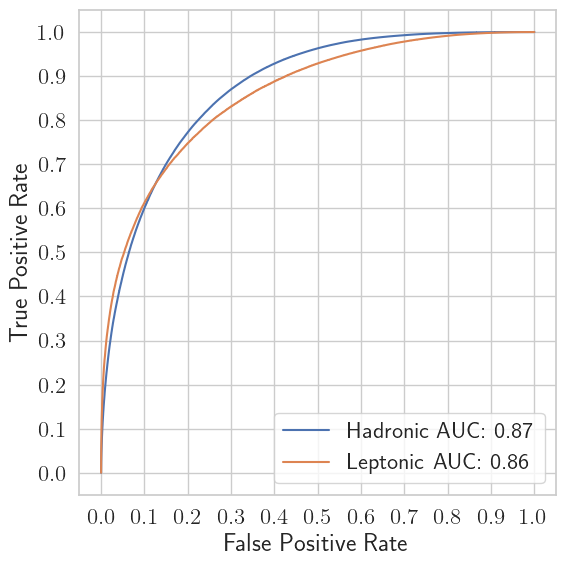

In [39]:
plt.figure(figsize=(6, 6))
roc_curve(ht_mask, evaluation.detection_probabilities["ht"], "Hadronic")
roc_curve(lt_mask, evaluation.detection_probabilities["lt"], "Leptonic")

plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.tight_layout();

Lets recreate the mass estimation but now using our detection cut as the mask for the predictions. This should help remove some of the background sculpting.

In [40]:
lt_treshhold = 0.5
lt_momenta_true = assignment_index(momenta, lt_truth, lt_mask)
lt_momenta_pred = assignment_index(momenta, evaluation.assignments["lt"], evaluation.detection_probabilities["lt"] > lt_treshhold)
lt_momenta_unmatched = assignment_index(momenta, evaluation.assignments["lt"], evaluation.detection_probabilities["lt"] < lt_treshhold)

ht_treshhold = 0.5
ht_momenta_true = assignment_index(momenta, ht_truth, ht_mask)
ht_momenta_pred = assignment_index(momenta, evaluation.assignments["ht"], evaluation.detection_probabilities["ht"] > ht_treshhold)
ht_momenta_unmatched = assignment_index(momenta, evaluation.assignments["ht"], evaluation.detection_probabilities["ht"] < ht_treshhold)

/Research/Feynman/spanet_demo/demo/helper.py:63: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_8308/417382682.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


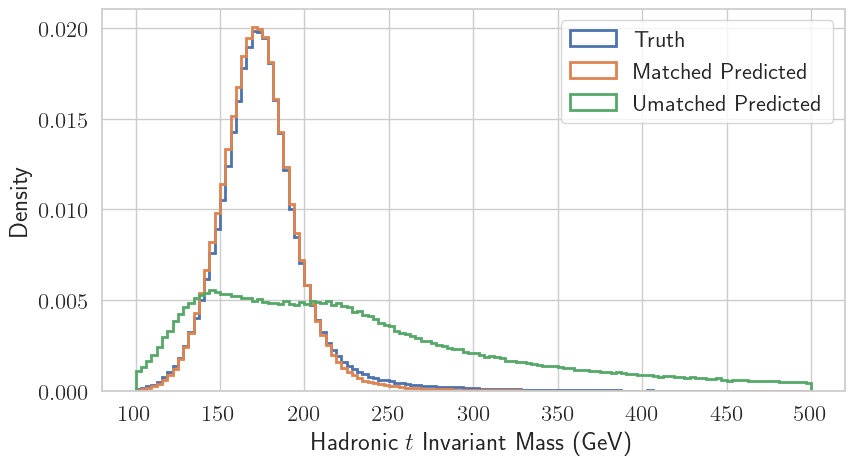

In [41]:
plot_distribution(invariant_mass(ht_momenta_true), line=2, label="Truth", range=(100, 500))
plot_distribution(invariant_mass(ht_momenta_pred), line=2, label="Matched Predicted", range=(100, 500))
plot_distribution(invariant_mass(ht_momenta_unmatched), line=2, label="Umatched Predicted", range=(100, 500))

plt.xlabel("Hadronic $t$ Invariant Mass (GeV)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout();

# Attention Plots

In [42]:
attention_outputs, handles = hook_attention([
    module.attention for module in
    model.encoder.encoder.layers
])

lt_attention_outputs, lt_handles = hook_attention([
    module.attention for module in
    model.branch_decoders[0].encoder.encoder.layers
])

ht_attention_outputs, ht_handles = hook_attention([
    module.attention for module in
    model.branch_decoders[1].encoder.encoder.layers
])

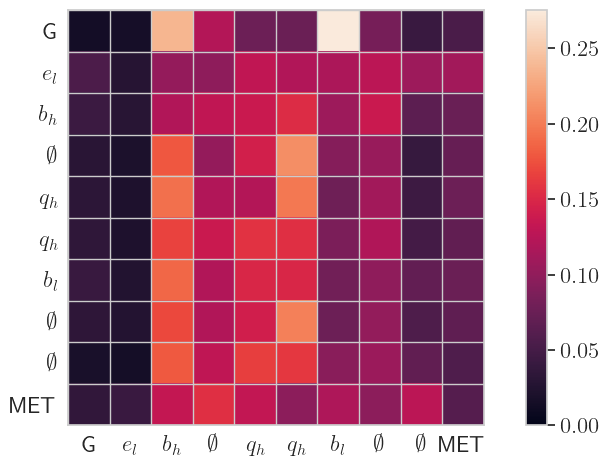

In [43]:
plot_attention(model, attention_outputs, example_validation_event)

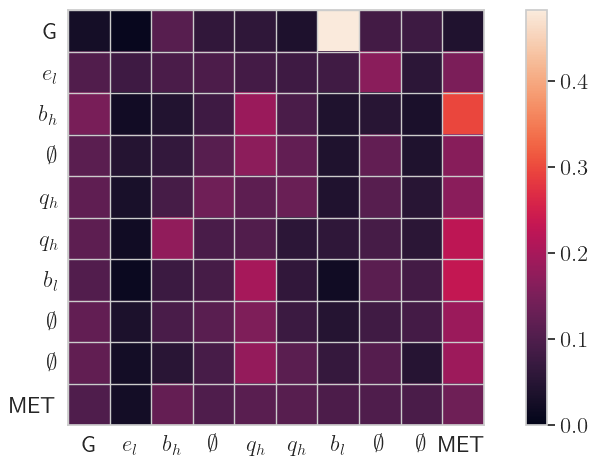

In [44]:
plot_attention(model, lt_attention_outputs, example_validation_event)

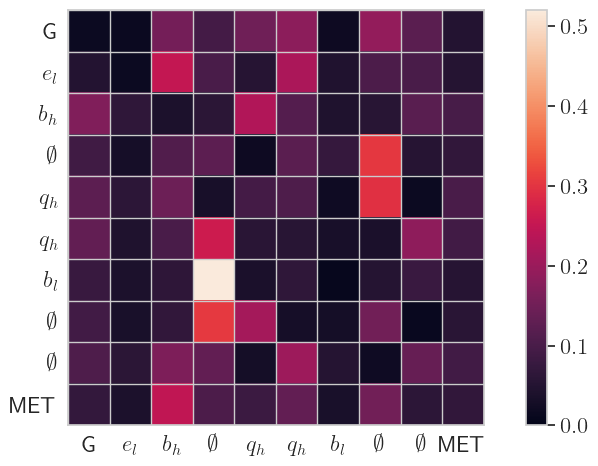

In [45]:
plot_attention(model, ht_attention_outputs, example_validation_event)